IA & Data science -- 2017-2018
--------
*&copy; Equipe pédagogique: Ludovic Denoyer, Thibault Laugel, Marie-Jeanne Lesot, Christophe Marsala, Olivier Schwander*

# TD-TME05: les arbres de décision

L'objectif de ce TP est d'implémenter un algorithme d'apprentissage supervisé, l'algorithme de construction d'arbres de décision (cours 6).

Comme pour les k-nn, nous allons nous restreindre à un cas binaire où les données sont étiquetées $+1$ ou $-1$. De plus, nous allons ne considérer que le cas où les attributs sont tous numériques.

<font size="+1">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

Harb Hassan et Chrétien Clément

<font color="RED" size="+1">IMPORTANT: soumission de votre fichier final</font>

**Nom à donner au fichier à poster** : *Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme
- ne pas compresser ou faire une archive: envoyer le fichier ipython tel quel, éventuellement, si vous avez d'autres fichiers à envoyer, vous les joignez au message.

## Préparation

Copier l'archive dans votre répertoire de travail: <code>/users/Enseignants/marsala/iads/tp5.tgz</code>

Décompresser l'archive, elle crée le répertoire "tp5" qui contient un fichier ipython à ouvrir (ce fichier-ci) et un sous-répertoire "data" contenant les bases d'apprentissage utilisées dans ce TP.

Le but de ce TP est de compléter ce document ipython en ajoutant les fonctions demandées. Avant de commencer, exécuter le bloc suivant afin de pouvoir initialiser des variables utiles 


In [320]:
# imports utiles
import numpy as np
import pandas as pd
import random
import math
import copy

## Etape 1: Retour sur les TD-TME précédents

Cette partie a été réalisée lors du TD-TME précédent, reprenez ce que vous avez fait en copier-collant votre travail de la semaine dernière.

Reprendre la classe <code>LabeledSet</code> du TD_TME précédent pour stocker les données d'apprentissage, de validation et de test. Cette classe permet de stocker des couples $\{(x_1,y_1),...,(x_n,y_n)\}$. Les $x_i$ et $y_i$ seront des tableaux numpy. 

In [164]:
class LabeledSet:  
    
    def __init__(self, input_dimension):
        self.input_dimension = input_dimension
        self.nb_examples = 0
    
    def addExample(self,vector,label):
        if (self.nb_examples == 0):
            self.x = np.array([vector])
            self.y = np.array([label])
        else:
            self.x = np.vstack((self.x, vector))
            self.y = np.vstack((self.y, label))
        
        self.nb_examples = self.nb_examples + 1
    
    #Renvoie la dimension de l'espace d'entrée
    def getInputDimension(self):
        return self.input_dimension
    
    #Renvoie le nombre d'exemples dans le set
    def size(self):
        return self.nb_examples
    
    #Renvoie la valeur de x_i
    def getX(self, i):
        return self.x[i]
        
    
    #Renvouie la valeur de y_i
    def getY(self, i):
        return(self.y[i])
    
    
    #Renvoie 2 labeledSet depuis 1 
    def split(self, pourcent):
        train = LabeledSet(self.input_dimension)
        test = LabeledSet(self.input_dimension)
        alea = [i for i in range(self.size())]
        random.shuffle(alea)
        for i in range(len(alea)):
            if i < pourcent * self.size() / 100:
                train.addExample(self.getX(alea[i]), self.getY(alea[i]))
            else:
                test.addExample(self.getX(alea[i]), self.getY(alea[i]))
        return train, test

In [165]:
def plot_frontiere(set, classifier, step=20):
    mmax = set.x.max(0)
    mmin = set.x.min(0)
    x1grid, x2grid = np.meshgrid(np.linspace(mmin[0], mmax[0], step), np.linspace(mmin[1], mmax[1], step))
    grid = np.hstack((x1grid.reshape(x1grid.size, 1), x2grid.reshape(x2grid.size, 1)))
    
    # calcul de la prediction pour chaque point de la grille
    res = np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res = res.reshape(x1grid.shape)
    # tracé des frontieres
    plt.contourf(x1grid, x2grid, res, colors=["red", "cyan"], levels=[-1000,0,1000], linewidth=2)

    
#Renvoie les points du labeledSet et en fonction de leur couleur
def points(labeledSet):
    xr = []
    yr = []
    xb = []
    yb = []
    for i in range(labeledSet.size()):  # Pour tous les exemples
        if labeledSet.getY(i) == 1:  # Si l'exemple appartient a la classe +1 on l'ajoute dans les listes associees
            xr.append(labeledSet.getX(i)[0])
            yr.append(labeledSet.getX(i)[1])
        else:
            xb.append(labeledSet.getX(i)[0])
            yb.append(labeledSet.getX(i)[1])
    return xr, yr, xb, yb

### Génération de données ''Jouet''

Comme lors des TD_TME précédents, les fonctions seront testées sur des données "jouet" générées selon des distributions choisies à la main. Commençons par un dataset en 2 dimensions (entrée) et 1 dimension (sortie): $x_i \in \mathbb{R}^2$, $y_i \in [-1;+1]$ telles que les données sont généres selon deux Gaussiennes. Pour cela, nous utiliserons la fonction numpy.random.multivariate_normal  - http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multivariate_normal.html 

* ''positive_center'' est le centre de la gaussienne des points positifs (vecteur de taille 2)
* ''positive_sigma'' est la variance de la gaussienne (sous forme de matrice 2*2)
* Idem pour ''negative''

* Générer une premiere gaussienne associée au label $+1$
* Y rajouter une seconde gaussienne associée au label $-1$

<font size="+1">**[Q]**</font>  Dans un premier temps, pour mettre au point les fonctions, génerer une base jouet assez petite (par exemple, 10 exemples de chaque classe).

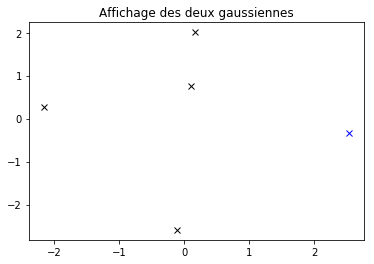

In [311]:
# Creation des Gaussiennes
# Exemple avec deux gaussiennes qui se "melangent"
mean1 = [1.5, 1.5]
mean2 = [-1.5, -1.5]
mat1 = np.random.multivariate_normal(mean1, [[3, 1],[1, 3]], 10).T
mat2 = np.random.multivariate_normal(mean2, [[3, 1],[1, 3]], 10).T
data = LabeledSet(2)
for i in range(len(mat1[0])):  # On ajoute les exemples au labeledSet
    data.addExample([mat1[0][i], mat1[1][i]], 1)
    data.addExample([mat2[0][i], mat2[1][i]], -1)
data_training, data_test = data.split(25)
xra, yra, xba, yba = points(data_training)
xrb, yrb, xbb, ybb = points(data_test)


# Affichage
plt.plot(xra, yra, 'bx')
plt.plot(xba, yba, 'kx')
plt.title("Affichage des deux gaussiennes")
plt.show()

In [167]:
S= data.x[np.where(data.y == 1),:]
S[0]

array([[10.88026468, 12.34554025],
       [13.20308471,  8.99864064],
       [11.77243099, 11.85622383],
       [10.00097825,  8.91919169],
       [ 8.7190292 , 10.60634117],
       [10.2537262 ,  9.83545922],
       [ 7.25212496,  8.17573628],
       [11.98567808, 11.72032065],
       [11.58275379, 10.22544509],
       [ 9.25420423,  7.80996887]])

Le dataset peut être affiché en utilisant matplotlib (pour vérifier). Nous utiliserons la commande matplotlib.pyplot.scatter permettant de dessiner un nuage de points - http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter -

In [313]:
import matplotlib.pyplot as plt
%matplotlib inline 

def plot2DSet(set):
    """ LabeledSet -> NoneType
        Hypothèse: set est de dimension 2
        affiche une représentation graphique du LabeledSet
        remarque: l'ordre des labels dans set peut être quelconque
    """
    S_pos = set.x[np.where(set.y == 1),:][0]      # tous les exemples de label +1
    S_neg = set.x[np.where(set.y == -1),:][0]     # tous les exemples de label -1
    plt.scatter(S_pos[:,0],S_pos[:,1],marker='o')
    plt.scatter(S_neg[:,0],S_neg[:,1],marker='x')

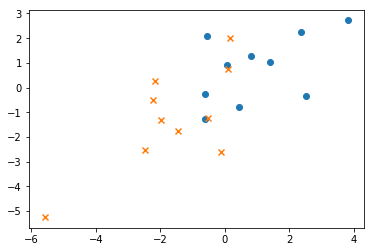

In [314]:
# Essai de la fonction : (the_set : variable du dataset généré précédemment)
plot2DSet(data)

### Les classifieurs

La classe <code>Classifier</code> sert toujours de classe de base: l'algorithme d'apprentissage par arbres de décision est un nouveau type de Classifier que l'on va créer.


In [170]:
class Classifier:
    def __init__(self,input_dimension):
        """ Constructeur """
        raise NotImplementedError("Please Implement this method")
    
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        raise NotImplementedError("Please Implement this method")

    
    # Permet d'entrainer le modele sur un ensemble de données
    def train(self,labeledSet):
        raise NotImplementedError("Please Implement this method")
    
    #Permet de calculer la qualité du système 
    def accuracy(self, dataset):
        nb_ok = 0
        for i in range(dataset.size()):
            output = self.predict(dataset.getX(i))
            if (output * dataset.getY(i) > 0):
                nb_ok = nb_ok + 1
        acc = nb_ok / (dataset.size() * 1.0)
        return acc    

On reprend la fonction suivante, utilisée lors des TD-TME précédent, pour dessiner la frontière de décision d'un classifieur.

In [171]:
def plot_frontiere(set,classifier,step=20):
    """ LabeledSet * Classifier * int -> NoneType
        Remarque: le 3e argument est optionnel et donne la "résolution" du tracé
        affiche la frontière de décision associée au classifieur
    """
    mmax = set.x.max(0)
    mmin = set.x.min(0)
    x1grid, x2grid = np.meshgrid(np.linspace(mmin[0], mmax[0], step), np.linspace(mmin[1], mmax[1], step))
    grid = np.hstack((x1grid.reshape(x1grid.size, 1), x2grid.reshape(x2grid.size, 1)))
    
    # calcul de la prediction pour chaque point de la grille
    res = np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res = res.reshape(x1grid.shape)
    # tracé des frontieres
    plt.contourf(x1grid, x2grid, res, colors=["red", "cyan"], levels=[-1000,0,1000], linewidth=2)    

In [172]:
# Exemple d'utilisation:
classifieur_random=ClassifierRandom(2)   # test avec la classe écrite dans les séances précédentes

classifieur_random.train(the_set)        # the_set a été initialisé précédemment

plot_frontiere(the_set,classifieur_random)   # on trace la frontière
plot2DSet(the_set)                           # on affiche le LabeledSet dessus


NameError: name 'ClassifierRandom' is not defined

<font size="+1">**[Q]**</font> Ecrire la fonction <code>classe_majoritaire()</code> qui, étant donné un LabeledSet rend la classe majoritaire dans l'ensemble (celle qui est possédée par le plus grand nombre d'exemples donc...). En cas d'égalité, cette fonction rend la classe +1.

In [262]:
def classe_majoritaire(labeledSet):
    a = sum(1 for i in range(labeledSet.nb_examples) if labeledSet.getY(i) == 1)  # Nombre d'exemple ayant pour classe +1
    b = sum(1 for i in range(labeledSet.nb_examples) if labeledSet.getY(i) == -1)
    if b > a:   # Si il y a plus d'exemple de la classe -1 alors on retourne -1 sinon 1 
        return -1
    else:
        return 1

In [174]:
classe_majoritaire(data)

1

## Etape 2: Arbres de décision

Dans cet étape, on réalise l'implémentation de l'algorithme de construction d'un arbre de décision.

### Entropie et gain d'information

Dans un premier temps, il est nécessaire écrire des fonctions pour calculer l'entropie et le gain d'information vus dans le cours 6.

Etant donné une distribution de probabilités $P=(p_1, p_2,..., p_k)$, l'entropie de Shannon de cette distribution est donnée par:

$ H_S(P) = -\sum_{i=1}^{k} p_i \log_k(p_i)$

Par convention, on considère que $0\log_k(0) = 0$. 

Le logarithme utilisé est le logarithme en base $k$ afin d'obtenir une valeur normalisée de l'entropie. La base du logarithme est donc $k$, le nombre de classes présentes dans la base au maximum.

Dans ce qui suit, en Python, une *distribution de probabilités* est représentée par une liste $P=[p_1,...,p_k]$ de valeurs réelles telle que
* pour tout $i=1,..., k$ : $0 \leq p_i \leq 1$
* $\sum_{i=1}^{k}p_i = 1$


<font size="+1">**[Q]**</font> Ecrire la fonction <code>shannon()</code> qui, étant donné une distribution de probabilités $P$, rend la valeur de l'entropie de Shannon correspondante.

Remarque: pour nous, en Python, $P$ est représentée par une liste de $k$ valeurs de $[0, 1]$ telle que la somme de toutes les valeurs vaut $1$.

In [175]:
def shannon(l):
    return -sum(i*math.log(i, len(l)) for i in l if i > 0)  # Somme des donnees de la liste donnee en argument a l'aide
                                                            # de la formule donnee

In [176]:
shannon([1, 0])

-0.0

In [177]:
shannon([0.5, 0.5])

1.0

In [178]:
shannon([0.25, 0.25, 0.25, 0.25])

1.0

In [179]:
shannon([0.7, 0.1, 0.2, 0.0])

0.5783898247235197

In [180]:
shannon([1.0/3, 2.0/3])

0.9182958340544896

<font size="+1">**[Q]**</font> A l'aide de la fonction <code>shannon()</code>, écrire la fonction <code>entropie()</code> qui prend un LabeledSet en argument et renvoie l'entropie de sa distribution des classes dans cet ensemble.

In [263]:
def entropie(labeledSet):
    a = sum(1 for i in range(labeledSet.nb_examples) if labeledSet.getY(i) == 1)  # Nombre d'exemple ayant pour classe +1 
    b = sum(1 for i in range(labeledSet.nb_examples) if labeledSet.getY(i) == -1)  
    return shannon([float(a)/(a+b), float(b)/(a+b)])  # Taux de presence de chaque classe d'exemple

In [182]:
entropie(data)

1.0

### Discrétisation des attributs numériques

Discrétiser un attribut numérique consiste en trouver un seuil de coupure dans son ensemble de valeurs. Pour trouver ce seuil, on sélectionne le point de coupure qui optimise la distribution des classes des exemples de chaque côté du seuil.

Par exemple, soit l'attribut Age contenant les valeurs 17, 18, 20, 27, 35, 37, 40. On discrétise cet attribut en 2 valeurs en déterminant un seuil de coupure comme, par exemple, le seuil 30: cela permet de séparer d'un côté les valeurs inférieures ou égales à 30, et de l'autre les valeurs strictement supérieures à 30.

Soit $E$ un ensemble d'exemples, et soit $X$ un attribut que l'on veut discrétiser. Pour cela, on constitue l'ensemble des valeurs prises par les exemples de $E$ pour l'attribut $X$. Soit $X_E$ cet ensemble de valeurs.
La discrétisation de $X_E$ s'effectue par les étapes suivantes:
- Etape 1: ordonner de façon croissante les valeurs de $X_E$;
- Etape 2: regarder tous les seuils possibles de coupure entre 2 valeurs consécutives de $X_E$ (on prend comme seuil de coupure la valeur entre ces 2 valeurs). Chaque seuil trouvé créé 2 intervalles qui générent 2 sous-ensembles de $E$: 
    1) l'ensemble $E_1$ des exemples dont la valeur pour l'attribut considéré et inférieure ou égale au seuil, et 2) l'ensemble $E_2$ des exemples dont la valeur pour l'attribut considéré et supérieure au seuil;
    - pour chacun des seuils trouvés: 
        - calculer l'entropie de la distribution des classes pour les exemples de l'ensemble $E_1$, et l'entropie de la distribution des classes  pour les exemples de $E_2$;
        - calculer l'entropie moyenne de la coupure engendrée par le seuil considéré:
$$H_{moy}(coupure) = \frac{|E_1|}{|E|} H_S(E_1) + \frac{|E_2|}{|E|} H_S(E_2);$$


La meilleure coupure pour discrétiser $X_E$ est celle qui minimise la valeur $H_{moy}(coupure)$.


Par exemple, soit $E=\{17, 18, 20, 27, 35, 37, 40\}$, chaque valeur étant associées aux classes +1, +1, -1, -1, +1, +1, -1 respectivement. Un seuil de coupure possible est $31$ ($31 = \frac{27+35}{2}$). Ce seuil coupe $E$ en $E_1=\{17, 18, 20, 27\}$ et $E_2=\{35, 37, 40\}$.

- pour $E_1$, la probabilité de chaque classe est: $p(+1)= 0.5$ et $p(-1)=0.5$ donc, $H_S(E_1)=1$;
- pour $E_2$, la probabilité de chaque classe est: $p(+1)= \frac{1}{3}$ et $p(-1)=\frac{2}{3}$ donc, $H_S(E_2)=0.9182958340544896$;
- on a donc: $$H_{moy}(coupure par 31) = \frac{4}{7} H_S(E_1) + \frac{3}{7} H_S(E_2);$$
soit $H_{moy}(coupure par 31) = 0.9182958340544896$

On considère que the_set est un LabeledSet construit précédement. Il contient deux variables de type array: x et y.

Regarder et tester les instructions suivantes, il faut bien comprendre comment elles fonctionnent car on va utiliser les mêmes principes dans les fonctions à écrire.

In [183]:
ind= np.argsort(data.x,axis=0)   # Tri des valeurs de the_set.x selon les colonnes. 
                                    # La fonction rend un numpy.ndarray contenant autant de 
                                    # colonnes que the_set.x et dans chaque colonne, on a 
                                    # la position de l'exemple dans l'ordonnancement croissant.
ind # pour afficher

array([[11, 13],
       [ 5, 11],
       [ 1, 19],
       [13,  7],
       [15, 15],
       [17, 17],
       [19,  3],
       [ 9,  1],
       [ 7,  5],
       [ 3,  9],
       [12, 18],
       [ 8, 12],
       [18,  6],
       [ 6,  2],
       [10, 10],
       [ 0, 16],
       [16,  8],
       [ 4, 14],
       [14,  4],
       [ 2,  0]])

In [184]:
data.x[ind[0:len(data.x),0]]  # Rend le numpy.array des exemples de the_set.x ordonnés
                                    # selon les indices donnés dans ind (colonne 0)


array([[-11.2405397 , -11.06598828],
       [-11.06752522,  -8.4932766 ],
       [-10.83749718,  -8.60695852],
       [-10.43846506, -11.45623197],
       [-10.20556255,  -9.72263726],
       [-10.1814302 ,  -9.51330903],
       [ -9.91875604, -10.50550037],
       [ -8.88891592,  -8.39297785],
       [ -8.56240026,  -9.72623371],
       [ -7.70570587,  -9.36092813],
       [  7.25212496,   8.17573628],
       [  8.7190292 ,  10.60634117],
       [  9.25420423,   7.80996887],
       [ 10.00097825,   8.91919169],
       [ 10.2537262 ,   9.83545922],
       [ 10.88026468,  12.34554025],
       [ 11.58275379,  10.22544509],
       [ 11.77243099,  11.85622383],
       [ 11.98567808,  11.72032065],
       [ 13.20308471,   8.99864064]])

In [185]:
data.y[ind[0:len(data.y),0]]  # Rend le numpy.array des exemples de the_set.y ordonnés
                                    # selon les indices donnés dans ind (colonne 0)

array([[-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1]])

In [186]:
colonne = 1    # numéro de la colonne de the_set.x à considérer
for v_i in ind[0:len(data.x)]:
    i = v_i[colonne]
    exem = data.getX(i)
    clas = data.getY(i)
    print("valeur=",exem[colonne], "classe= ", clas[0])

('valeur=', -11.456231971205728, 'classe= ', -1)
('valeur=', -11.06598828383721, 'classe= ', -1)
('valeur=', -10.505500366503083, 'classe= ', -1)
('valeur=', -9.72623370858072, 'classe= ', -1)
('valeur=', -9.722637257240244, 'classe= ', -1)
('valeur=', -9.513309028364434, 'classe= ', -1)
('valeur=', -9.36092812833515, 'classe= ', -1)
('valeur=', -8.606958521213633, 'classe= ', -1)
('valeur=', -8.493276600772932, 'classe= ', -1)
('valeur=', -8.392977849307307, 'classe= ', -1)
('valeur=', 7.809968865358803, 'classe= ', 1)
('valeur=', 8.175736282677187, 'classe= ', 1)
('valeur=', 8.91919169311086, 'classe= ', 1)
('valeur=', 8.998640644155413, 'classe= ', 1)
('valeur=', 9.835459222655714, 'classe= ', 1)
('valeur=', 10.22544508561473, 'classe= ', 1)
('valeur=', 10.606341174922532, 'classe= ', 1)
('valeur=', 11.720320646739092, 'classe= ', 1)
('valeur=', 11.85622383445418, 'classe= ', 1)
('valeur=', 12.345540254512542, 'classe= ', 1)


Etant donné un LabeledSet, ainsi qu'un numéro de colonne à considérer (qui correspond à un des attributs de description), la fonction <code>discrétise()</code> rend un tuple constitué de la valeur de coupure qui minimise l'entropie de Shannon moyenne, et de la valeur de l'entropie trouvée.

In [187]:
def discretise(LSet, col):
    """ LabelledSet * int -> tuple[float, float]
        col est le numéro de colonne sur X à discrétiser
        rend la valeur de coupure qui minimise l'entropie ainsi que son entropie.
    """
    # initialisation:
    min_entropie = 1.1  # on met à une valeur max car on veut minimiser
    min_seuil = 0.0     
    # trie des valeurs:
    ind= np.argsort(LSet.x,axis=0)
    
    # calcul des distributions des classes pour E1 et E2:
    inf_plus  = 0               # nombre de +1 dans E1
    inf_moins = 0               # nombre de -1 dans E1
    sup_plus  = 0               # nombre de +1 dans E2
    sup_moins = 0               # nombre de -1 dans E2       
    # remarque: au départ on considère que E1 est vide et donc E2 correspond à E. 
    # Ainsi inf_plus et inf_moins valent 0. Il reste à calculer sup_plus et sup_moins 
    # dans E.
    for j in range(0,LSet.size()):
        if (LSet.getY(j) == -1):
            sup_moins += 1
        else:
            sup_plus += 1
    nb_total = (sup_plus + sup_moins) # nombre d'exemples total dans E
    
    # parcours pour trouver le meilleur seuil:
    for i in range(len(LSet.x)-1):
        v_ind_i = ind[i]   # vecteur d'indices
        courant = LSet.getX(v_ind_i[col])[col]
        lookahead = LSet.getX(ind[i+1][col])[col]
        val_seuil = (courant + lookahead) / 2.0;
        # M-A-J de la distrib. des classes:
        # pour réduire les traitements: on retire un exemple de E2 et on le place
        # dans E1, c'est ainsi que l'on déplace donc le seuil de coupure.
        if LSet.getY(ind[i][col])[0] == -1:
            inf_moins += 1
            sup_moins -= 1
        else:
            inf_plus += 1
            sup_plus -= 1
        # calcul de la distribution des classes de chaque côté du seuil:
        nb_inf = (inf_moins + inf_plus)*1.0     # rem: on en fait un float pour éviter
        nb_sup = (sup_moins + sup_plus)*1.0     # que ce soit une division entière.
        # calcul de l'entropie de la coupure
        val_entropie_inf = shannon([inf_moins / nb_inf, inf_plus  / nb_inf])
        val_entropie_sup = shannon([sup_moins / nb_sup, sup_plus  / nb_sup])
        val_entropie = (nb_inf / nb_total) * val_entropie_inf + (nb_sup / nb_total) * val_entropie_sup
        # si cette coupure minimise l'entropie, on mémorise ce seuil et son entropie:
        if (min_entropie > val_entropie):
            min_entropie = val_entropie
            min_seuil = val_seuil
    return (min_seuil, min_entropie)

In [188]:
discretise(data,0) # le résultat dépend, bien sûr, de la base jouet

(-0.2267904562142089, -0.0)

In [189]:
discretise(data,1) # le résultat dépend, bien sûr, de la base jouet

(-0.2915044919742522, -0.0)

Une dernière fonction utile permet de diviser une base d'exemples en 2 sous-bases en utilisant un seuil sur la valeur d'un attribut donné.

<font size="+1">**[Q]**</font> Ecrire la fonction divise() dont la spécification est:

    def divise(LSet,att,seuil):
        """ LSet: LabeledSet
            att : numéro d'attribut
            seuil : valeur de seuil
            rend le tuple contenant les 2 sous-LabeledSet obtenus par la
            division de LSet selon le seuil sur l'attribut att
        """



In [196]:
def divise(LSet,att,seuil):
    """ LSet: LabeledSet
        att : numéro d'attribut
        seuil : valeur de seuil
        rend le tuple contenant les 2 sous-LabeledSet obtenus par la
        division de LSet selon le seuil sur l'attribut att
    """
    a = LabeledSet(2)
    b = LabeledSet(2)
    for i in range(LSet.size()):  # Pour chaque exemple on le range dans l'un des deux labeledSet
        if LSet.getX(i)[att] <= seuil:  # Si il se trouve en dessous du seuil on le met dans l'un sinon dans l'autre
            a.addExample(LSet.getX(i), LSet.getY(i))
        else:
            b.addExample(LSet.getX(i), LSet.getY(i))
    return a, b  # Tuple contenant les deux labeledSet crees
    

In [191]:
Linf, Lsup = divise(data,0,-0.5)
print("entropie inferieur:",entropie(Linf)," / entropie superieur:", entropie(Lsup))
# remarque: les résultats dépendent de votre base jouet...

('entropie inferieur:', -0.0, ' / entropie superieur:', -0.0)


### Représentation d'un arbre en Python

Un arbre de décision est doit être représenté en Python, pour cela, on utilise la classe <code>ArbreBinaire</code> suivante:

In [192]:
import graphviz as gv

class ArbreBinaire:
    def __init__(self):
        self.attribut = None   # numéro de l'attribut
        self.seuil = None
        self.inferieur = None # ArbreBinaire Gauche (valeurs <= au seuil)
        self.superieur = None # ArbreBinaire Droit (valeurs > au seuil)
        self.classe = None # Classe si c'est une feuille: -1 ou +1
        
    def est_feuille(self):
        """ rend True si l'arbre est une feuille """
        return self.seuil == None
    
    def ajoute_fils(self,ABinf,ABsup,att,seuil):
        """ ABinf, ABsup: 2 arbres binaires
            att: numéro d'attribut
            seuil: valeur de seuil
        """
        self.attribut = att
        self.seuil = seuil
        self.inferieur = ABinf
        self.superieur = ABsup
    
    def ajoute_feuille(self,classe):
        """ classe: -1 ou + 1
        """
        self.classe = classe
        
    def classifie(self,exemple):
        """ exemple : numpy.array
            rend la classe de l'exemple: +1 ou -1
        """
        if self.est_feuille():
            return self.classe
        if exemple[self.attribut] <= self.seuil:
            return self.inferieur.classifie(exemple)
        return self.superieur.classifie(exemple)
    
    def to_graph(self, g, prefixe='A'):
        """ construit une représentation de l'arbre pour pouvoir
            l'afficher
        """
        if self.est_feuille():
            g.node(prefixe,str(self.classe),shape='box')
        else:
            g.node(prefixe, str(self.attribut))
            self.inferieur.to_graph(g,prefixe+"g")
            self.superieur.to_graph(g,prefixe+"d")
            g.edge(prefixe,prefixe+"g", '<='+ str(self.seuil))
            g.edge(prefixe,prefixe+"d", '>'+ str(self.seuil))
        
        return g

True


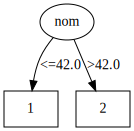

In [193]:
# Exemple d'utilisation: 
un_arbre= ArbreBinaire()
un_arbre.ajoute_feuille(1)
print(un_arbre.est_feuille())
un_arbre1 = ArbreBinaire()
un_arbre1.ajoute_feuille(2)
un_arbre2 = ArbreBinaire()
un_arbre2.ajoute_fils(un_arbre,un_arbre1,"nom",42.0)

gtree = gv.Digraph(format='png')
un_arbre2.to_graph(gtree)

### Construction de l'arbre de décision

Pour construire un arbre de décision, il faut réaliser les étapes suivantes:
- si l'entropie de Shannon de la distribution des classes de l'ensemble courant est inférieure à epsilon (réel positif fixé et qui est un paramètre de l'algorithme), alors construire une feuille avec cet ensemble, la classe associée à cette feuille est la classe majoritaire;
- sinon, pour chaque attribut, calculer le seuil de discrétisation et l'entropie de Shannon correspondante
    - choisir l'attribut qui donne une valeur d'entropie minimale
    - l'attribut choisi sert à constituer un noeud de l'arbre de décision, les arcs issus de ce noeud sont labeller par un test (inférieur ou égal ou supérieur) par rapport au seuil trouvé
    
    
<font size="+1">**[Q]**</font> Ecrire la fonction qui construit un arbre de décision (binaire) à partir d'une base d'exemples. En plus de la base d'exemples, on utilise un argument "epsilon" qui est un réel >0 et qui sert pour le critère d'arrêt.
Cette fonction a la spécification suivante:

    def construit_AD(LSet,epsilon):
        """ LSet : LabeledSet
            epsilon : seuil d'entropie pour le critère d'arrêt 
        """


In [281]:
def construit_AD(LSet,epsilon):
    """ LSet : LabeledSet
        epsilon : seuil d'entropie pour le critère d'arrêt 
    """
    arbre = ArbreBinaire()  # On cree un arbreBinaire
     
        
    if entropie(LSet) <= epsilon:  # Si l'entropie du lset est inferieur ou egal a l'epsilon que l'on a fixe 
        arbre.ajoute_feuille(classe_majoritaire(LSet))  # On ajoute une feuille qui aura pour label la classe majoritaire
        return arbre  # On renvoie l'arbre 
    
    
    else:
        min_ent = 2  # On fixe une entropie a 2 de cette facon on est certain de trouver plus petit
        min_seuil = -1  
        att = -1
        
        for i in range(len(LSet.getX(0))):  # Pour le nombre d'attribut du set
            d = discretise(LSet, i)  # On discretise cet attribut
            if min_ent > d[1]:  # Si l'entropie est plus petite
                min_ent = d[1]
                min_seuil = d[0]
                att = i
                
        new_lset1, new_lset2 = divise(LSet, att, min_seuil)  # On cree 2 lset grace au parametre recuperer precedement
        
        #  On ajoute a l'arbre deux fils qui seront eux même des feuilles ou des arbres
        arbre.ajoute_fils(construit_AD(new_lset1, epsilon), construit_AD(new_lset2, epsilon), att, min_seuil)
        return arbre
        
        

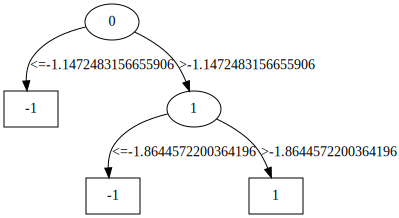

In [282]:
#test de l'affichage 
abin = construit_AD(data,0.0)
gtree = gv.Digraph(format='png')
abin.to_graph(gtree)

### Classification avec arbre de décision


Pour classer un nouvel exemple avec un arbre de décision, il faut parcourir l'arbre, de la racine vers une feuille en respectant les tests rencontrés dans chaque arc. Une fois atteint une feuille, la classe de l'exemple est celle présente dans la feuille.

La classe ArbreBinaire contient déjà une fonction <code>classifie</code> qui permet de classer un nouvel exemple et de renvoyer la classe +1 ou -1 selon le cas.

### Implémentation

De la même façon que pour le knn, on définit le classifieur <code>ArbreDecision</code> (classe héritant de la classe Classifier vue lors du TD-TME 5) comme suit.

Si toutes les fonctions précédentes ont été écrites correctement, il est maintenant possible de construire un arbre de décision à partir de la base jouet.


## Applications à des données réelles

In [284]:
class ArbreDecision(Classifier):
    # Constructeur
    def __init__(self,epsilon):
        # valeur seuil d'entropie pour arrêter la construction
        self.epsilon= epsilon
        self.racine = None
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        # classification de l'exemple x avec l'arbre de décision
        # on rend 0 (classe -1) ou 1 (classe 1)
        classe = self.racine.classifie(x)
        if (classe == 1):
            return(1)
        else:
            return(-1)
    
    # Permet d'entrainer le modele sur un ensemble de données
    def train(self,set):
        # construction de l'arbre de décision 
        self.set=set
        self.racine = construit_AD(set,self.epsilon)

    # Permet d'afficher l'arbre
    def plot(self):
        gtree = gv.Digraph(format='png')
        return self.racine.to_graph(gtree)
        

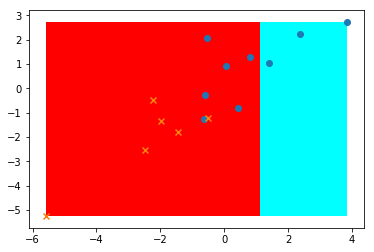

In [315]:
# un exemple d'utilisation:
ad=ArbreDecision(0.0)          # initialiation d'un arbre binaire qui utilisera epsilon= 0.0
ad.train(data_training)              # construction de l'arbre à partir de la base jouet
plot_frontiere(data_test,ad,20)  # tracé graphique de la frontière de décision
plot2DSet(data_test) 

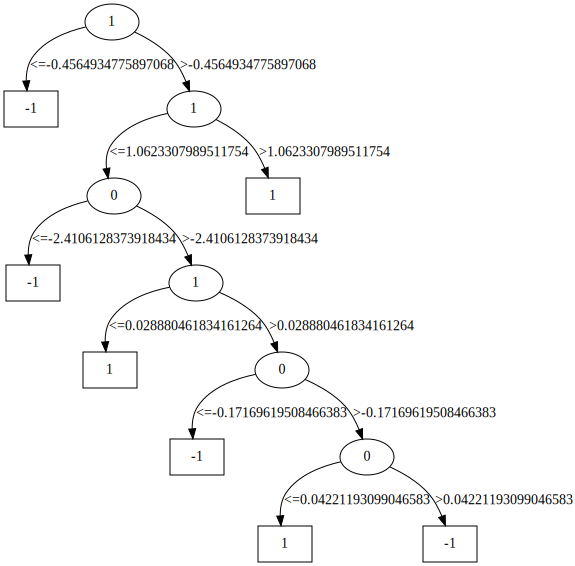

In [289]:
ad.plot()

<font size="+1">**[Q]**</font> Appliquer l'algorithme des arbres de décision à des données réelles (par exemple, celles utilisées avec les k-nn) et comparer les résultats obtenus par les 2 algorithmes.

Un autre exemple d'utilisation sur une base plus grande:

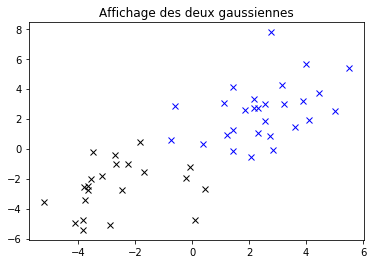

In [341]:
# Creation des Gaussiennes
# Exemple avec deux gaussiennes qui se "melangent"
mean1 = [2.5, 2.5]
mean2 = [-2.5, -2.5]
mat1 = np.random.multivariate_normal(mean1, [[3, 1],[1, 3]], 100).T
mat2 = np.random.multivariate_normal(mean2, [[3, 1],[1, 3]], 100).T
data2 = LabeledSet(2)
for i in range(len(mat1[0])):  # On ajoute les exemples au labeledSet
    data2.addExample([mat1[0][i], mat1[1][i]], 1)
    data2.addExample([mat2[0][i], mat2[1][i]], -1)
data_training2, data_test2 = data2.split(25)
xra, yra, xba, yba = points(data_training2)
xrb, yrb, xbb, ybb = points(data_test2)


# Affichage
plt.plot(xra, yra, 'bx')
plt.plot(xba, yba, 'kx')
plt.title("Affichage des deux gaussiennes")
plt.show()

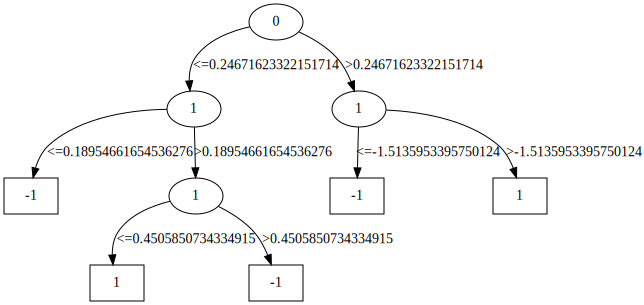

In [342]:
adautre.plot()

### Améliorations (facultatif)

Adapter votre algorithme afin de pouvoir construire des arbres de décision avec des attributs catégoriels.

## Etape 3: Expérimentation

Comparez le résultat obtenu avec ceux obtenus avec les 2 classifiers implémentés lors des TD-TME précédents. Ensuite, utilisez votre implémentation sur d'autres bases de données que vous avez déjà trouvées ou que vous pourrez trouver sur le web.

In [336]:
import scipy.spatial

class KNN(Classifier):
    def __init__(self, input_dimension, k, lset):
        self.input_dimension = input_dimension
        self.k = k
        self.data = []
        self.labeledSet = lset
        
    def train(self, labeledSet):
        for i in range(labeledSet.size()):
            self.data.append((labeledSet.getX(i), labeledSet.getY(i)))
        
    def predict(self, x):
        dist = []
        for i in range(self.labeledSet.size()):
            d = scipy.spatial.distance.euclidean(x, self.labeledSet.getX(i))
            if d != 0:
                dist.append(d)
        dist = np.argsort(dist)
        somme = 0
        for i in range(self.k):
            somme += self.labeledSet.getY(dist[i])
        if somme < 0:
            return -1
        else:
            return 1

In [334]:
class KernelPoly:
    def transform(self,x):
            return np.asarray([x[0], x[1], x[0]*x[1], x[0]**2, x[1]**2, 1])

class PerceptronKernel(Classifier):
    def __init__(self,dimension_kernel,learning_rate,kernel, nb_iterations):
        self.dimension_kernel = dimension_kernel
        self.learning_rate = learning_rate
        self.kernel = kernel
        self.w = np.random.rand(dimension_kernel) * 2 - 1
        self.nb_iterations = nb_iterations
        
    #Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        x = self.kernel.transform(x)
        a = sum(self.w[i]*x[i] for i in range(len(x)))
        return a
    
    #Permet d'entrainer le modele sur un ensemble de données
    def train(self,labeledSet):
        alea = [k for k in range(labeledSet.size())]
        random.shuffle(alea)
        for j in alea:
            t = self.kernel.transform(labeledSet.getX(j))
            if self.predict(t)*labeledSet.getY(j) < 0:
                self.w = self.w + self.learning_rate * labeledSet.getY(j) * t     
    
    
    def iterate(self, test, training):
        train_acc = []
        test_acc = []
        train_acc.append(self.accuracy(training))
        test_acc.append(self.accuracy(test))
        for i in range(self.nb_iterations):
            old_w = copy.deepcopy(self.w)
            self.train(training)
            train_acc.append(self.accuracy(training))
            test_acc.append(self.accuracy(test))
            if np.array_equal(old_w, self.w):
                break
        return test_acc, train_acc                     
        

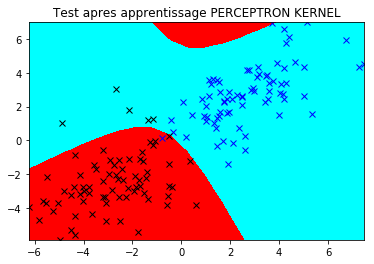

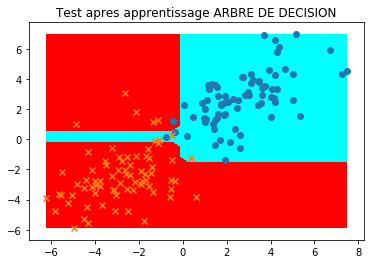

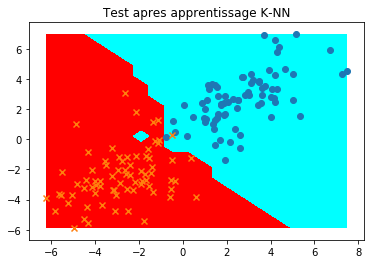

In [340]:
# Affichage après itération


# Affichage des donnees avec utilisation du classifieur Perceptron avec kernel trick
k=KernelPoly()
perceptron_k=PerceptronKernel(6, 0.0003, k, 1000)
perceptron_k.iterate(data_test2, data_training2)
plt.plot(xrb, yrb, 'bx')
plt.plot(xbb, ybb, 'kx')
plt.title("Test apres apprentissage PERCEPTRON KERNEL")
plot_frontiere(data_test2, perceptron_k)
plt.show()

# Affichage des donnees avec utilisation du classifieur Arbre de Decision
adautre=ArbreDecision(0.0)          
adautre.train(data_training2)            
plot_frontiere(data_test2,adautre,20)
plt.title("Test apres apprentissage ARBRE DE DECISION")
plot2DSet(data_test2)
plt.show()

# Affichage des donnees avec utilisation du classifieur K-NN
knn = KNN(2, 2, data2)
knn.train(data_training2)
plot_frontiere(data_test2,knn,20)
plt.title("Test apres apprentissage K-NN")
plot2DSet(data_test2) 